In [ ]:
pip install sklearn matplotlib plotly

In [ ]:
pip install transformers

In [5]:
pip install scikit-learn

In [12]:
import os
import json
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch
from sklearn.manifold import TSNE
import numpy as np
from google.colab import files
import plotly.graph_objs as go


# Initialize tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
# Load the configuration and set output_hidden_states to True
config = AutoConfig.from_pretrained("bucketresearch/politicalBiasBERT", output_hidden_states=True)
model = AutoModelForSequenceClassification.from_pretrained("bucketresearch/politicalBiasBERT", config=config)

In [7]:
# Load JSON files from the directory
data_dir = "./data"
all_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.json')]

In [8]:
# Function to get BERT embeddings
def get_bert_embeddings(text):
    tokenized_inputs = tokenizer(text, truncation=True, return_tensors='pt', max_length=512)
    inputs = {'input_ids': tokenized_inputs['input_ids'], 'attention_mask': tokenized_inputs['attention_mask']}
    with torch.no_grad():
        outputs = model(**inputs)
    # Get the embeddings from one of the last layers
    embeddings = outputs.hidden_states[-2][0].mean(dim=0)

    return embeddings.numpy()

In [10]:
embeddings = []
# Getting the embeddings from the dataset
true_labels = []
i=0
for file in tqdm(all_files):
    with open(file, 'r') as f:
        article = json.load(f)

    title = article['title']
    body = " ".join([sent['sentence'] for sent in article['body']])
    full_text = title + " " + body

    emb = get_bert_embeddings(full_text)
    embeddings.append(emb)
    true_label = article['article-level-annotations']['stance'].lower()
    true_labels.append(true_label)

    # i+=1
    # if i > 40:
    #   break

# Convert the list of embeddings to a NumPy array
embeddings_array = np.array(embeddings)

100%|██████████| 300/300 [09:35<00:00,  1.92s/it]


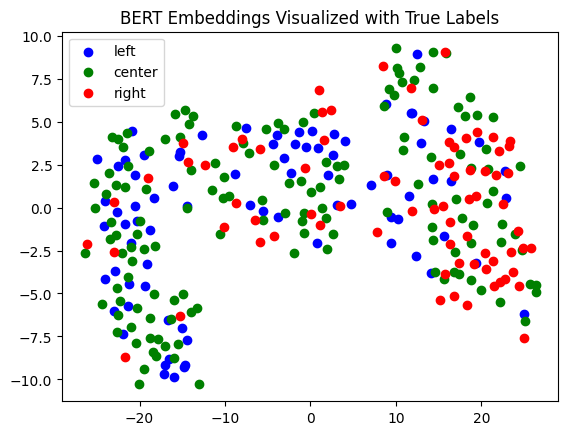

In [14]:
# Dimensionality Reduction
embeddings_reduced = TSNE(n_components=2, random_state=42).fit_transform(embeddings_array)

# Plotting
unique_labels = set(true_labels)
for label in unique_labels:
    indices = [i for i, x in enumerate(true_labels) if x == label]
    color = 'red' if label == 'right' else 'blue' if label == 'left' else 'green'
    plt.scatter(embeddings_reduced[indices, 0], embeddings_reduced[indices, 1], c=color, label=label)
plt.legend()
plt.title("BERT Embeddings Visualized with True Labels")
plt.show()

kNN

In [ ]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Convert textual labels to numerical labels
numerical_labels = label_encoder.fit_transform(true_labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(embeddings_array, numerical_labels, test_size=0.2, random_state=42)

# Initialize the KNN classifier
knn = KNeighborsClassifier(n_neighbors=10)

# Train the classifier
knn.fit(X_train, y_train)

# Make predictions
y_pred = knn.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.5333333333333333


3D visualizations

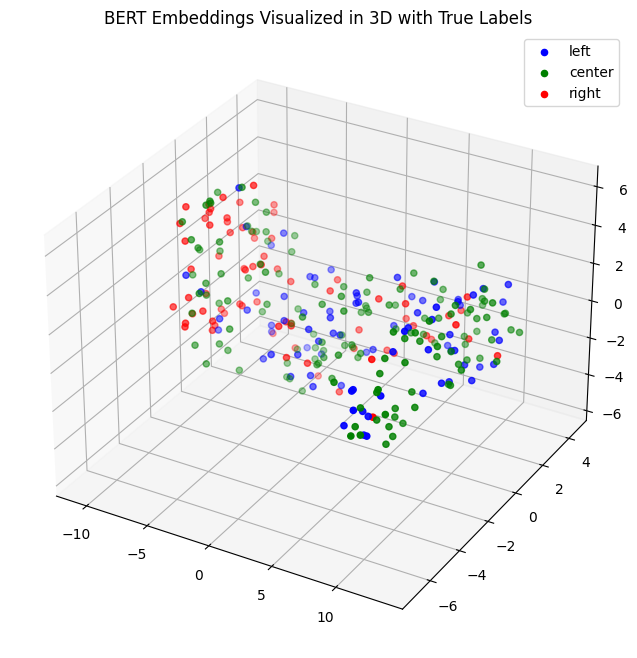

In [15]:
# 3D t-SNE Visualization
tsne_3d = TSNE(n_components=3, random_state=42)
embeddings_3d = tsne_3d.fit_transform(embeddings_array)

# Plotting
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

colors = {'left': 'blue', 'right': 'red', 'center': 'green'}
unique_labels = set(true_labels)
for label in unique_labels:
    indices = [i for i, x in enumerate(true_labels) if x == label]
    ax.scatter(embeddings_3d[indices, 0], embeddings_3d[indices, 1], embeddings_3d[indices, 2], c=colors[label], label=label)

ax.legend()
ax.set_title("BERT Embeddings Visualized in 3D with True Labels")
plt.show()


In [ ]:
tsne_3d = TSNE(n_components=3, random_state=42)
embeddings_3d = tsne_3d.fit_transform(embeddings_array)

# Create a trace for each different label
traces = []
colors = {'left': 'blue', 'center': 'green', 'right': 'red'}
for label in set(true_labels):
    indices = [i for i, l in enumerate(true_labels) if l == label]
    trace = go.Scatter3d(
        x=embeddings_3d[indices, 0],
        y=embeddings_3d[indices, 1],
        z=embeddings_3d[indices, 2],
        mode='markers',
        marker=dict(
            size=5,
            opacity=0.8,
            line=dict(width=0.5, color='white'),
            color=colors[label]
        ),
        name=label
    )
    traces.append(trace)

# Define the layout of the plot
layout = go.Layout(
    title="BERT Embeddings Visualized in 3D with True Labels",
    margin=dict(l=0, r=0, b=0, t=30),
    legend=dict(x=0.1, y=1, xanchor="left", yanchor="top"),
    # scene=dict(
    #     xaxis=dict(title='Component 1'),
    #     yaxis=dict(title='Component 2'),
    #     zaxis=dict(title='Component 3'),
    # )
)

# Create the figure and plot it
fig = go.Figure(data=traces, layout=layout)
fig.show()

In [ ]:
fig.write_html('Emb_Plot.html')

In [ ]:
files.download('Emb_Plot.html')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>